# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups
Sample_181  Q8IXL6           15.890
Sample_104  P00739           19.588
Sample_136  O75874           13.491
Sample_058  P55291           16.914
Sample_055  P19652           25.657
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups 
Sample_064  Q14563            14.574
Sample_117  P13647            15.271
Sample_104  P40121;P40121-2   15.068
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.780
            A0A075B6Q5                 13.767
            A0A075B6R2                 11.479
            A0A075B6S5                 13.157
            A0A087WSY4                 13.367
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.192
            Q9UI40;Q9UI40-2            13.798
            Q9UIW2                     13.048
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.825
            Q9UP79                     12.852
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.373,15.050,16.842,19.863,15.822,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.994,19.067,...,15.528,15.576,14.205,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.858,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.616,17.705,17.039,16.040,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.574,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.344,15.345,17.084,18.708,14.249,19.433,11.168,11.146
Sample_207,15.739,16.877,15.469,16.898,15.446,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.208,13.634,13.179,13.443,12.795,13.301,12.589,14.214,13.288,13.586
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.639,19.067,16.127,...,13.292,12.373,12.213,13.975,12.648,11.890,13.105,13.184,12.618,12.709
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.757,13.708,12.633,12.964,13.903,12.483,12.151,13.012,13.313,13.269
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.239,13.200,12.185,12.834,11.979,13.092,13.587,13.589,13.894,11.901
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,12.168,15.029,12.655,13.292,14.114,12.796,12.783,12.560,13.260,13.307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.839,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 315.03it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.33it/s]

100%|██████████| 2/2 [00:00<00:00,  4.22it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.58it/s]

100%|██████████| 3/3 [00:00<00:00,  4.11it/s]

100%|██████████| 3/3 [00:00<00:00,  4.33it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.77it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.43it/s]

100%|██████████| 4/4 [00:01<00:00,  3.04it/s]

100%|██████████| 4/4 [00:01<00:00,  3.28it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.84it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.98it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.40it/s]

100%|██████████| 5/5 [00:01<00:00,  2.88it/s]

100%|██████████| 5/5 [00:01<00:00,  3.27it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.84it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.19it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.50it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.19it/s]

100%|██████████| 6/6 [00:01<00:00,  3.12it/s]

100%|██████████| 6/6 [00:01<00:00,  3.41it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.53it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.73it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.01it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.08it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.87it/s]

100%|██████████| 7/7 [00:02<00:00,  2.73it/s]

100%|██████████| 7/7 [00:02<00:00,  3.23it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  8.57it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.84it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.22it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.52it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.05it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.77it/s]

100%|██████████| 8/8 [00:02<00:00,  2.57it/s]

100%|██████████| 8/8 [00:02<00:00,  3.20it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.40it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.35it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.72it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.41it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.01it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.97it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.31it/s]

100%|██████████| 9/9 [00:02<00:00,  3.01it/s]

100%|██████████| 9/9 [00:02<00:00,  3.73it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  8.41it/s]

 30%|███       | 3/10 [00:00<00:01,  5.64it/s]

 40%|████      | 4/10 [00:00<00:01,  4.52it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.22it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.20it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.16it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.97it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.42it/s]

100%|██████████| 10/10 [00:02<00:00,  3.24it/s]

100%|██████████| 10/10 [00:02<00:00,  3.91it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.35it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.71it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.03it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.30it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.03it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.17it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.18it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  4.33it/s]

 91%|█████████ | 10/11 [00:02<00:00,  4.20it/s]

100%|██████████| 11/11 [00:02<00:00,  4.34it/s]

100%|██████████| 11/11 [00:02<00:00,  4.49it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.90it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.24it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.84it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.65it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.41it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.09it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.04it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  4.05it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.13it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.23it/s]

100%|██████████| 12/12 [00:02<00:00,  3.95it/s]

100%|██████████| 12/12 [00:02<00:00,  4.29it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.96it/s]

 23%|██▎       | 3/13 [00:00<00:01,  6.70it/s]

 31%|███       | 4/13 [00:00<00:01,  6.07it/s]

 38%|███▊      | 5/13 [00:00<00:01,  5.21it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.64it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.41it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.20it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.10it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.17it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.16it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.35it/s]

100%|██████████| 13/13 [00:02<00:00,  3.80it/s]

100%|██████████| 13/13 [00:02<00:00,  4.47it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  8.21it/s]

 21%|██▏       | 3/14 [00:00<00:02,  5.46it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.91it/s]

 36%|███▌      | 5/14 [00:00<00:01,  4.66it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.53it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.21it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  3.77it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.77it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.68it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.79it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  3.97it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.98it/s]

100%|██████████| 14/14 [00:03<00:00,  4.19it/s]

100%|██████████| 14/14 [00:03<00:00,  4.24it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.59it/s]

 20%|██        | 3/15 [00:00<00:02,  4.76it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.20it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.89it/s]

 40%|████      | 6/15 [00:01<00:02,  4.08it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.12it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  3.69it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.62it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.74it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.85it/s]

 80%|████████  | 12/15 [00:02<00:00,  3.87it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.97it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  4.01it/s]

100%|██████████| 15/15 [00:03<00:00,  4.14it/s]

100%|██████████| 15/15 [00:03<00:00,  4.06it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.005      0.043 0.019          0.780 0.338       0.129   
2             0.004 0.004      0.052 0.022          0.785 0.088       0.714   
3             0.004 0.003      0.046 0.018          0.785 0.100       0.736   
4             0.006 0.005      0.047 0.018          0.804 0.091       0.787   
5             0.006 0.005      0.054 0.023          0.804 0.089       0.786   
6             0.004 0.002      0.042 0.012          0.827 0.079       0.833   
7             0.006 0.006      0.048 0.017          0.829 0.085       0.841   
8             0.004 0.002      0.055 0.024          0.829 0.085       0.832   
9             0.004 0.003      0.046 0.016          0.819 0.082       0.826   
10            0.005 0.004      0.043 0.016          0.818 0.084       0.820   
11            0.006 0.005      0.048 0.017          0.817 0.083       0.815   
12            0.007 0.007      0.054 0.019          0.824 0.087       0.804   
13            0.005 0.004      0.051 0.018          0.822 0.089       0.800   
14            0.006 0.004      0.055 0.020          0.824 0.087       0.806   
15            0.005 0.004      0.048 0.020          0.820 0.082       0.804   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.096   0.212 0.142                  0.557 0.047        0.860   
2          0.108   0.742 0.076                  0.783 0.059        0.856   
3          0.113   0.753 0.085                  0.791 0.067        0.884   
4          0.117   0.788 0.076                  0.821 0.063        0.890   
5          0.111   0.789 0.074                  0.821 0.060        0.893   
6          0.104   0.826 0.073                  0.852 0.062        0.917   
7          0.112   0.830 0.076                  0.856 0.064        0.916   
8          0.114   0.825 0.075                  0.851 0.063        0.914   
9          0.104   0.818 0.072                  0.845 0.061        0.917   
10         0.115   0.814 0.077                  0.842 0.065        0.916   
11         0.109   0.811 0.073                  0.840 0.061        0.915   
12         0.100   0.810 0.075                  0.838 0.062        0.924   
13         0.104   0.806 0.077                  0.835 0.064        0.922   
14         0.097   0.811 0.072                  0.838 0.060        0.921   
15         0.097   0.808 0.070                  0.836 0.058        0.919   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.831 0.090        210.000 0.000  
2          0.061                  0.817 0.076        210.000 0.000  
3          0.060                  0.857 0.083        210.000 0.000  
4          0.053                  0.863 0.068        210.000 0.000  
5          0.053                  0.865 0.066        210.000 0.000  
6          0.045                  0.898 0.053        210.000 0.000  
7          0.045                  0.898 0.052        210.000 0.000  
8          0.046                  0.896 0.054        210.000 0.000  
9          0.045                  0.900 0.053        210.000 0.000  
10         0.044                  0.898 0.053        210.000 0.000  
11         0.045                  0.897 0.053        210.000 0.000  
12         0.044                  0.912 0.048        210.000 0.000  
13         0.044                  0.910 0.048        210.000 0.000  
14         0.044                  0.909 0.049        210.000 0.000  
15         0.046                  0.906 0.050 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 456.80it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.19it/s]

100%|██████████| 2/2 [00:00<00:00,  7.13it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  8.18it/s]

100%|██████████| 3/3 [00:00<00:00,  5.82it/s]

100%|██████████| 3/3 [00:00<00:00,  6.15it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.85it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.83it/s]

100%|██████████| 4/4 [00:00<00:00,  4.03it/s]

100%|██████████| 4/4 [00:00<00:00,  4.43it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.55it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.41it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.27it/s]

100%|██████████| 5/5 [00:01<00:00,  3.94it/s]

100%|██████████| 5/5 [00:01<00:00,  4.36it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.61it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.46it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.73it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.60it/s]

100%|██████████| 6/6 [00:01<00:00,  3.03it/s]

100%|██████████| 6/6 [00:01<00:00,  3.70it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.53it/s]

 43%|████▎     | 3/7 [00:00<00:00,  6.08it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  5.27it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  4.55it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.14it/s]

100%|██████████| 7/7 [00:01<00:00,  3.28it/s]

100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  8.00it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.56it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.63it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.36it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.08it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.88it/s]

100%|██████████| 8/8 [00:01<00:00,  3.40it/s]

100%|██████████| 8/8 [00:01<00:00,  4.05it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.39it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.85it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.79it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  4.75it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.36it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.21it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.40it/s]

100%|██████████| 9/9 [00:02<00:00,  2.87it/s]

100%|██████████| 9/9 [00:02<00:00,  3.77it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.89it/s]

 30%|███       | 3/10 [00:00<00:01,  5.63it/s]

 40%|████      | 4/10 [00:00<00:01,  4.75it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.48it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.75it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.16it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.89it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.49it/s]

100%|██████████| 10/10 [00:03<00:00,  2.33it/s]

100%|██████████| 10/10 [00:03<00:00,  3.10it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.81it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.29it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.69it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.42it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.21it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.99it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.89it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.72it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.19it/s]

100%|██████████| 11/11 [00:03<00:00,  2.76it/s]

100%|██████████| 11/11 [00:03<00:00,  3.62it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.06it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.55it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.99it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.02it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.06it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  3.19it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.39it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.29it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  3.17it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.97it/s]

100%|██████████| 12/12 [00:03<00:00,  2.79it/s]

100%|██████████| 12/12 [00:03<00:00,  3.10it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.77it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.99it/s]

 31%|███       | 4/13 [00:00<00:02,  4.49it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.28it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.93it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.93it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  3.79it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.86it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.75it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.32it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.08it/s]

100%|██████████| 13/13 [00:03<00:00,  2.66it/s]

100%|██████████| 13/13 [00:03<00:00,  3.51it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.33it/s]

 21%|██▏       | 3/14 [00:00<00:02,  5.09it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.51it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.36it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.02it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.80it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.73it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.70it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.84it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  3.00it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.89it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.70it/s]

100%|██████████| 14/14 [00:04<00:00,  2.40it/s]

100%|██████████| 14/14 [00:04<00:00,  2.92it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.50it/s]

 20%|██        | 3/15 [00:00<00:03,  3.80it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.31it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.21it/s]

 40%|████      | 6/15 [00:01<00:02,  3.29it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.18it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.22it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.33it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.44it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.46it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.40it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.20it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.29it/s]

100%|██████████| 15/15 [00:04<00:00,  3.36it/s]

100%|██████████| 15/15 [00:04<00:00,  3.39it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.005      0.058 0.026          0.047 0.191       0.006   
2             0.004 0.002      0.056 0.020          0.613 0.188       0.257   
3             0.007 0.007      0.065 0.028          0.649 0.139       0.416   
4             0.006 0.006      0.067 0.021          0.649 0.143       0.437   
5             0.005 0.003      0.053 0.019          0.765 0.101       0.654   
6             0.005 0.005      0.047 0.018          0.762 0.095       0.661   
7             0.004 0.003      0.047 0.016          0.764 0.099       0.662   
8             0.005 0.004      0.048 0.017          0.803 0.087       0.809   
9             0.008 0.007      0.076 0.025          0.804 0.085       0.814   
10            0.005 0.004      0.049 0.016          0.802 0.087       0.816   
11            0.007 0.006      0.063 0.026          0.797 0.086       0.818   
12            0.006 0.004      0.051 0.019          0.793 0.087       0.812   
13            0.006 0.005      0.061 0.026          0.797 0.088       0.807   
14            0.004 0.002      0.044 0.013          0.796 0.088       0.792   
15            0.005 0.004      0.048 0.016          0.791 0.086       0.788   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.024   0.010 0.042                  0.499 0.012        0.862   
2          0.108   0.345 0.113                  0.562 0.047        0.692   
3          0.114   0.495 0.101                  0.621 0.061        0.678   
4          0.125   0.510 0.111                  0.627 0.069        0.673   
5          0.105   0.701 0.089                  0.752 0.069        0.814   
6          0.106   0.703 0.086                  0.754 0.067        0.814   
7          0.113   0.704 0.090                  0.755 0.069        0.813   
8          0.110   0.802 0.079                  0.831 0.067        0.906   
9          0.111   0.805 0.079                  0.834 0.067        0.905   
10         0.109   0.805 0.079                  0.833 0.067        0.907   
11         0.106   0.804 0.079                  0.832 0.067        0.906   
12         0.107   0.798 0.078                  0.828 0.067        0.905   
13         0.105   0.798 0.079                  0.828 0.067        0.904   
14         0.098   0.790 0.076                  0.821 0.065        0.906   
15         0.096   0.786 0.075                  0.817 0.064        0.907   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.828 0.087        210.000 0.000  
2          0.096                  0.605 0.108        210.000 0.000  
3          0.074                  0.608 0.087        210.000 0.000  
4          0.079                  0.610 0.090        210.000 0.000  
5          0.070                  0.789 0.087        210.000 0.000  
6          0.069                  0.787 0.088        210.000 0.000  
7          0.071                  0.784 0.091        210.000 0.000  
8          0.049                  0.884 0.056        210.000 0.000  
9          0.050                  0.883 0.057        210.000 0.000  
10         0.050                  0.887 0.057        210.000 0.000  
11         0.049                  0.887 0.056        210.000 0.000  
12         0.048                  0.886 0.055        210.000 0.000  
13         0.049                  0.884 0.056        210.000 0.000  
14         0.049                  0.887 0.056        210.000 0.000  
15         0.048                  0.890 0.055 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1071.07it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 32.85it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 18.85it/s]

100%|██████████| 3/3 [00:00<00:00, 18.60it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 21.49it/s]

100%|██████████| 4/4 [00:00<00:00, 20.11it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 23.55it/s]

100%|██████████| 5/5 [00:00<00:00, 19.22it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 23.39it/s]

100%|██████████| 6/6 [00:00<00:00, 17.55it/s]

100%|██████████| 6/6 [00:00<00:00, 18.11it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 21.58it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 15.09it/s]

100%|██████████| 7/7 [00:00<00:00, 15.04it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 24.89it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 17.78it/s]

100%|██████████| 8/8 [00:00<00:00, 16.32it/s]

100%|██████████| 8/8 [00:00<00:00, 17.17it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 19.54it/s]

 44%|████▍     | 4/9 [00:00<00:00, 17.26it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 14.41it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 13.67it/s]

100%|██████████| 9/9 [00:00<00:00, 14.17it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 21.82it/s]

 60%|██████    | 6/10 [00:00<00:00, 17.13it/s]

 80%|████████  | 8/10 [00:00<00:00, 14.93it/s]

100%|██████████| 10/10 [00:00<00:00, 15.13it/s]

100%|██████████| 10/10 [00:00<00:00, 15.75it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 21.47it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 15.61it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 15.78it/s]

 91%|█████████ | 10/11 [00:00<00:00, 13.92it/s]

100%|██████████| 11/11 [00:00<00:00, 15.17it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 26.11it/s]

 50%|█████     | 6/12 [00:00<00:00, 18.03it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 16.84it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 15.57it/s]

100%|██████████| 12/12 [00:00<00:00, 15.36it/s]

100%|██████████| 12/12 [00:00<00:00, 16.37it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 22.36it/s]

 46%|████▌     | 6/13 [00:00<00:00, 16.25it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 15.72it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 15.36it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 15.17it/s]

100%|██████████| 13/13 [00:00<00:00, 15.70it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 20.53it/s]

 43%|████▎     | 6/14 [00:00<00:00, 16.59it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 15.97it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 14.61it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 15.51it/s]

100%|██████████| 14/14 [00:00<00:00, 15.12it/s]

100%|██████████| 14/14 [00:00<00:00, 15.58it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 21.74it/s]

 40%|████      | 6/15 [00:00<00:00, 14.82it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 13.92it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 14.14it/s]

 80%|████████  | 12/15 [00:00<00:00, 13.35it/s]

 93%|█████████▎| 14/15 [00:01<00:00, 13.16it/s]

100%|██████████| 15/15 [00:01<00:00, 13.72it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.042 0.014          0.000 0.000       0.000   
2             0.004 0.003      0.048 0.020          0.698 0.176       0.239   
3             0.003 0.000      0.044 0.016          0.623 0.100       0.490   
4             0.005 0.005      0.053 0.020          0.627 0.091       0.531   
5             0.004 0.002      0.041 0.015          0.636 0.087       0.528   
6             0.006 0.005      0.052 0.017          0.648 0.090       0.556   
7             0.004 0.002      0.039 0.013          0.674 0.090       0.599   
8             0.004 0.003      0.048 0.017          0.663 0.084       0.599   
9             0.004 0.003      0.040 0.011          0.660 0.084       0.601   
10            0.005 0.005      0.048 0.017          0.666 0.088       0.611   
11            0.004 0.003      0.043 0.013          0.658 0.094       0.597   
12            0.004 0.003      0.048 0.019          0.662 0.091       0.630   
13            0.004 0.004      0.039 0.020          0.669 0.091       0.636   
14            0.004 0.002      0.044 0.015          0.672 0.090       0.639   
15            0.006 0.005      0.052 0.017          0.669 0.089       0.637   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.740   
2          0.092   0.342 0.105                  0.575 0.043        0.591   
3          0.103   0.542 0.085                  0.634 0.065        0.737   
4          0.103   0.568 0.078                  0.648 0.058        0.769   
5          0.102   0.570 0.078                  0.651 0.057        0.770   
6          0.110   0.593 0.085                  0.666 0.063        0.767   
7          0.110   0.629 0.089                  0.693 0.064        0.790   
8          0.115   0.624 0.089                  0.688 0.063        0.787   
9          0.110   0.624 0.085                  0.687 0.062        0.783   
10         0.105   0.632 0.083                  0.692 0.063        0.780   
11         0.106   0.620 0.085                  0.683 0.064        0.775   
12         0.111   0.639 0.085                  0.695 0.065        0.796   
13         0.114   0.645 0.087                  0.701 0.064        0.796   
14         0.113   0.648 0.086                  0.703 0.065        0.794   
15         0.115   0.645 0.086                  0.701 0.064        0.790   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.690 0.084        210.000 0.000  
2          0.070                  0.574 0.067        210.000 0.000  
3          0.068                  0.683 0.067        210.000 0.000  
4          0.062                  0.708 0.070        210.000 0.000  
5          0.062                  0.715 0.070        210.000 0.000  
6          0.061                  0.707 0.070        210.000 0.000  
7          0.061                  0.729 0.079        210.000 0.000  
8          0.061                  0.723 0.078        210.000 0.000  
9          0.062                  0.718 0.081        210.000 0.000  
10         0.061                  0.719 0.076        210.000 0.000  
11         0.062                  0.715 0.076        210.000 0.000  
12         0.061                  0.734 0.075        210.000 0.000  
13         0.062                  0.733 0.076        210.000 0.000  
14         0.061                  0.732 0.076        210.000 0.000  
15         0.061                  0.724 0.078 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,12,9,15
score_time,8,9,4
test_precision,7,9,2
test_recall,7,11,14
test_f1,7,9,14
test_balanced_accuracy,7,9,14
test_roc_auc,12,15,12
test_average_precision,12,15,12
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  6.85it/s]

 20%|██        | 3/15 [00:00<00:02,  4.38it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.06it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.85it/s]

 40%|████      | 6/15 [00:01<00:02,  3.80it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.62it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.07it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.80it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.50it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.28it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.24it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.14it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.14it/s]

100%|██████████| 15/15 [00:05<00:00,  2.16it/s]

100%|██████████| 15/15 [00:05<00:00,  2.70it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 18.83it/s]

 42%|████▏     | 5/12 [00:00<00:00, 16.31it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 16.18it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 13.53it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 13.94it/s]

100%|██████████| 12/12 [00:00<00:00, 14.54it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 10.15it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.77it/s]

 42%|████▏     | 5/12 [00:00<00:01,  5.04it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.07it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.49it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.30it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.13it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.08it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.23it/s]

100%|██████████| 12/12 [00:03<00:00,  3.33it/s]

100%|██████████| 12/12 [00:03<00:00,  3.70it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


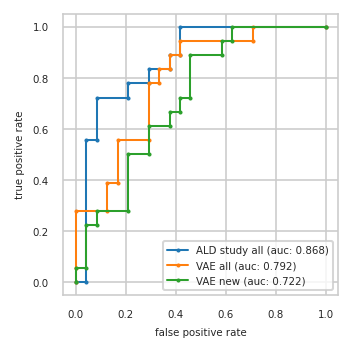

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.042 0.000   0.000 0.056   0.000 0.056
2          0.042 0.556   0.000 0.278   0.042 0.056
3          0.083 0.556   0.125 0.278   0.042 0.222
4          0.083 0.722   0.125 0.389   0.083 0.222
5          0.208 0.722   0.167 0.389   0.083 0.278
6          0.208 0.778   0.167 0.556   0.208 0.278
7          0.292 0.778   0.292 0.556   0.208 0.500
8          0.292 0.833   0.292 0.778   0.292 0.500
9          0.375 0.833   0.333 0.778   0.292 0.611
10         0.375 0.889   0.333 0.833   0.375 0.611
11         0.417 0.889   0.375 0.833   0.375 0.667
12         0.417 1.000   0.375 0.889   0.417 0.667
13         1.000 1.000   0.417 0.889   0.417 0.722
14           NaN   NaN   0.417 0.944   0.458 0.722
15           NaN   NaN   0.708 0.944   0.458 0.889
16           NaN   NaN   0.708 1.000   0.583 0.889
17           NaN   NaN   1.000 1.000   0.583 0.944
18           NaN   NaN     NaN   NaN   0.625 0.944
19           NaN   NaN     NaN   NaN   0.625 1.000
20           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q13433,H0YLF3,B1AJQ6;Q86Y82
2,A0A0A0MRJ7;P12259,P01258;P01258-2;P06881,G3V295;G3V3I1;G3V5Z7;P60900
3,P14174,P61981,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
4,P61981,Q9Y2T3;Q9Y2T3-3,P31321
5,P04075,P04075,P51688
6,Q9Y2T3;Q9Y2T3-3,P14174,J3KSJ8;Q9UD71;Q9UD71-2
7,Q99983,Q14894,Q96GD0
8,P00338;P00338-3,P63104,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


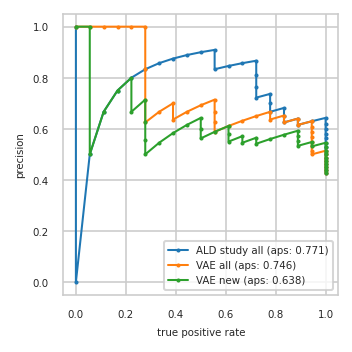

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.529 1.000     0.500 0.944     0.529 1.000
9          0.545 1.000     0.515 0.944     0.545 1.000
10         0.562 1.000     0.531 0.944     0.531 0.944
11         0.581 1.000     0.548 0.944     0.548 0.944
12         0.600 1.000     0.567 0.944     0.533 0.889
13         0.621 1.000     0.586 0.944     0.552 0.889
14         0.643 1.000     0.607 0.944     0.571 0.889
15         0.630 0.944     0.630 0.944     0.593 0.889
16         0.615 0.889     0.615 0.889     0.577 0.833
17         0.640 0.889     0.640 0.889     0.560 0.778
18         0.625 0.833     0.625 0.833     0.542 0.722
19         0.652 0.833     0.652 0.833     0.565 0.722
20         0.682 0.833     0.636 0.778     0.545 0.667
21         0.667 0.778     0.667 0.778     0.571 0.667
22         0.700 0.778     0.650 0.722     0.550 0.611
23         0.737 0.778     0.632 0.667     0.579 0.611
24         0.722 0.722     0.611 0.611     0.611 0.611
25         0.765 0.722     0.588 0.556     0.588 0.556
26         0.812 0.722     0.625 0.556     0.562 0.500
27         0.867 0.722     0.667 0.556     0.600 0.500
28         0.857 0.667     0.714 0.556     0.643 0.500
29         0.846 0.611     0.692 0.500     0.615 0.444
30         0.833 0.556     0.667 0.444     0.583 0.389
31         0.909 0.556     0.636 0.389     0.545 0.333
32         0.900 0.500     0.700 0.389     0.500 0.278
33         0.889 0.444     0.667 0.333     0.556 0.278
34         0.875 0.389     0.625 0.278     0.625 0.278
35         0.857 0.333     0.714 0.278     0.714 0.278
36         0.833 0.278     0.833 0.278     0.667 0.222
37         0.800 0.222     1.000 0.278     0.800 0.222
38         0.750 0.167     1.000 0.222     0.750 0.167
39         0.667 0.111     1.000 0.167     0.667 0.111
40         0.500 0.056     1.000 0.111     0.500 0.056
41         0.000 0.000     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


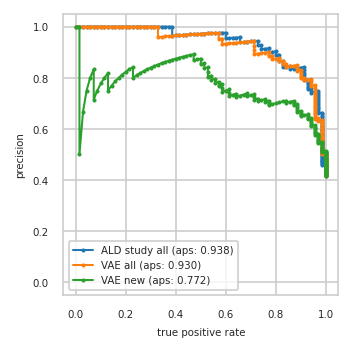

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


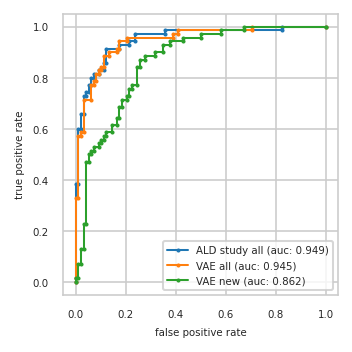

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}